# Neural ODEs for Periodic Systems


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchdiffeq
import scipy
import pandas as pd
import matplotlib.animation as animation
import matplotlib.pyplot as plt


## Generate Data

In [3]:
# create a simple periodic system
def simple_periodic_system(t, y):
    return torch.sin(y)


# create a periodic ODE system with a periodic forcing term
def periodic_system_ode(t, y):
    # Unpack the state variables
    # y[0] is position x, y[1] is velocity v
    omega = 2.0  # natural frequency
    gamma = 0.1  # damping coefficient
    # The system of first-order ODEs:
    # dx/dt = v
    # dv/dt = -omega^2 * x - gamma * v
    dydt = torch.zeros_like(y)
    dydt[0] = y[1]
    dydt[1] = -omega**2 * y[0] - gamma * y[1]
    return dydt

<Figure size 1200x600 with 0 Axes>

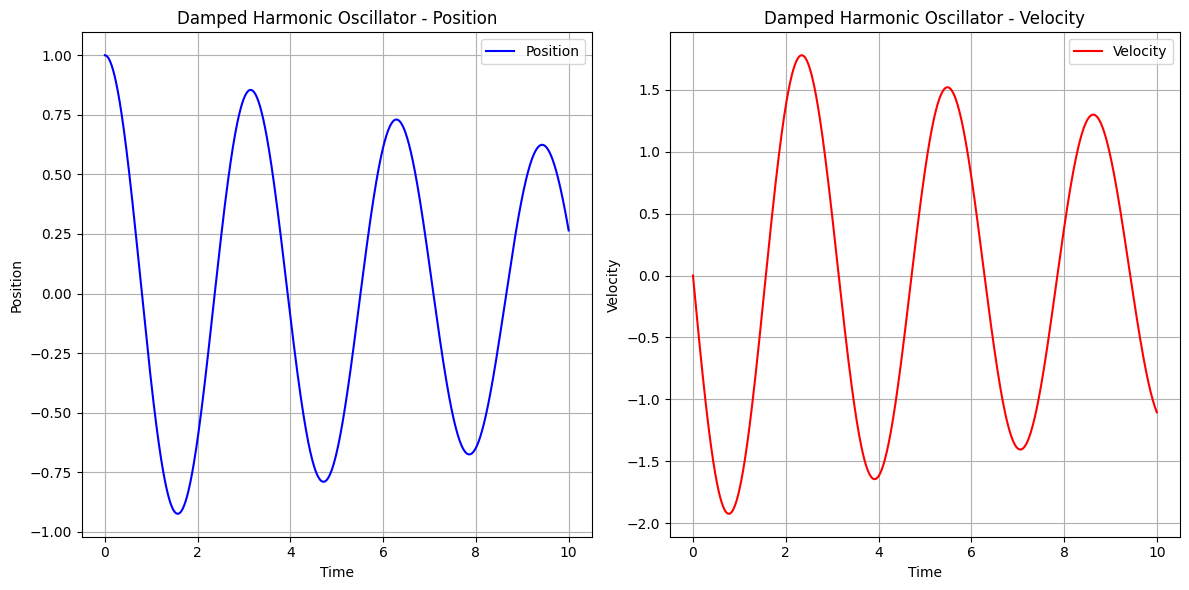

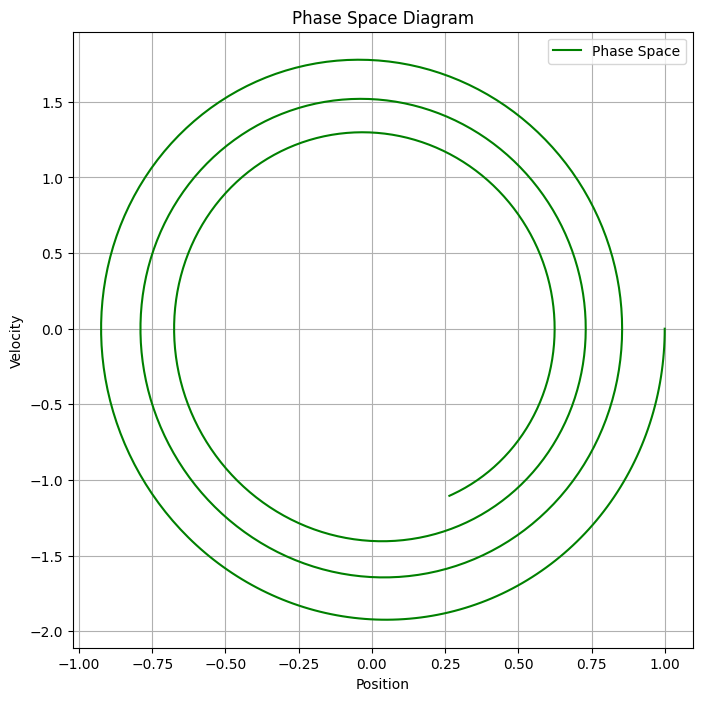

In [15]:
# Set up initial conditions and time points
plt.figure(figsize=(12, 6))
t_span = torch.linspace(0, 10, 1000)  # 10 seconds, 1000 points
initial_state = torch.tensor([1.0, 0.0])  # Initial position = 1, Initial velocity = 0

# Solve the ODE system
solution = torchdiffeq.odeint(
    periodic_system_ode,
    initial_state,
    t_span,
    method='rk4'  # Using 4th order Runge-Kutta method
)
# Plot the results
plt.figure(figsize=(12, 6))
# Plot position
plt.subplot(1, 2, 1)
plt.plot(t_span, solution[:, 0], 'b-', label='Position')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator - Position')
plt.legend()
plt.grid(True)

# Plot velocity
plt.subplot(1, 2, 2)
plt.plot(t_span, solution[:, 1], 'r-', label='Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Damped Harmonic Oscillator - Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
# Create phase space plot
plt.figure(figsize=(8, 8))
plt.plot(solution[:, 0], solution[:, 1], 'g-', label='Phase Space')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space Diagram')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
solution.shape


torch.Size([1000, 2])

## Fit the Data with Neural ODEs


In [6]:
data = solution.detach().numpy()
t_data = t_span.numpy()
train_size = int(0.8 * len(t_data))
t_train = torch.tensor(t_data[:train_size], dtype=torch.float32)
t_test = torch.tensor(t_data[train_size:], dtype=torch.float32)
y_train = torch.tensor(data[:train_size], dtype=torch.float32)
y_test = torch.tensor(data[train_size:], dtype=torch.float32)

In [7]:
# Define the Neural ODE model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )
    
    def forward(self, t, y):
        return self.net(y)

In [26]:
func = ODEFunc()
optimizer = optim.Adam(func.parameters(), lr=0.005)
batch_time_steps = 150  # Number of time steps per batch
n_epochs = 200

In [31]:
def train_neural_ode(func, optimizer, batch_time_steps, n_epochs):
    optimizer = optim.Adam(func.parameters(), lr=0.005)
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        pred = torchdiffeq.odeint(
            func,
            initial_state,
            t_train,
            method='rk4'
        )
        
        # Compute loss
        loss = nn.MSELoss()(pred, y_train)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}')
    return losses

In [32]:
# Evaluate on test set
def evaluate_neural_ode(func, t_test, y_test):
    with torch.no_grad():
        pred_test = torchdiffeq.odeint(
            func,
            initial_state,
            t_test,
            method='rk4'
        )
        test_loss = nn.MSELoss()(pred_test, y_test)
        print(f'\nTest Loss: {test_loss.item():.6f}')
    return pred_test

In [29]:
# Plot results
def plot_trainig_losses(losses):
    plt.figure(figsize=(15, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.yscale('log')

In [30]:
# Plot training loss
def plot_predictions(t_span, solution, pred_full):
    #  Plot predictions vs actual
    plt.subplot(1, 2, 1)
    with torch.no_grad():
        pred_full = torchdiffeq.odeint(func, initial_state, t_span, method='rk4')
    plt.plot(t_span, solution[:, 0], 'b-', label='True Position')
    plt.plot(t_span, pred_full[:, 0], 'r--', label='Predicted Position')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Position: True vs Predicted')
    plt.legend()

    # Phase space plot
    plt.subplot(1, 2, 2)
    plt.plot(solution[:, 0], solution[:, 1], 'b-', label='True')
    plt.plot(pred_full[:, 0], pred_full[:, 1], 'r--', label='Predicted')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Phase Space')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 10/200, Loss: 0.920227
Epoch 20/200, Loss: 0.851612
Epoch 30/200, Loss: 0.840021
Epoch 40/200, Loss: 0.830463
Epoch 50/200, Loss: 0.822692
Epoch 60/200, Loss: 0.816031
Epoch 70/200, Loss: 0.809628
Epoch 80/200, Loss: 0.802663
Epoch 90/200, Loss: 0.794687
Epoch 100/200, Loss: 0.784910
Epoch 110/200, Loss: 0.771839
Epoch 120/200, Loss: 0.752037
Epoch 130/200, Loss: 0.713934
Epoch 140/200, Loss: 0.562001
Epoch 150/200, Loss: 0.660232
Epoch 160/200, Loss: 0.697913
Epoch 170/200, Loss: 0.649027
Epoch 180/200, Loss: 0.568994
Epoch 190/200, Loss: 0.336585
Epoch 200/200, Loss: 0.061979

Test Loss: 2.756755


C:\Users\xuzey\AppData\Local\Temp\ipykernel_14688\4198955780.py:23: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


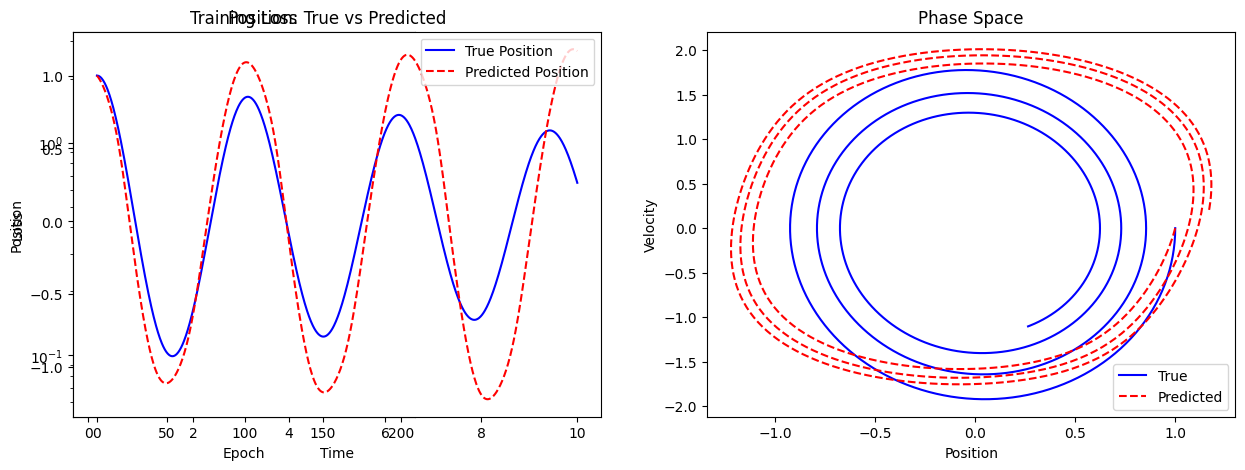

In [33]:
losses = train_neural_ode(func, optimizer, batch_time_steps, n_epochs)
pred_full = evaluate_neural_ode(func, t_test, y_test)
plot_trainig_losses(losses)
plot_predictions(t_span, solution, pred_full)

examine the periodic spectrum of the prediction and the actual result using fourier transform


In [40]:
t_data = t_span.numpy()
dt = t_data[1] - t_data[0]  # time step
fs = 1/dt  # sampling frequency
fs

np.float32(99.9)

In [38]:
from scipy import signal
from matplotlib.patches import Patch
from scipy.fft import fft, fftfreq

def get_frequency_modes(data, fs=100):
    # Perform FFT
    n = len(data)
    yf = fft(data)
    xf = fftfreq(n, 1/fs)
    
    # Get positive frequencies only
    pos_freq_mask = xf > 0
    return xf[pos_freq_mask], np.abs(yf[pos_freq_mask])



def plot_spetrogram(pred_full, solution):
    # Get position data
    pred_positions = pred_full[:, 0].numpy()
    true_positions = solution[:, 0].numpy()

    # Calculate frequency modes
    freq_pred, amp_pred = get_frequency_modes(pred_positions)
    freq_true, amp_true = get_frequency_modes(true_positions)

    # Create vertical subplot
    plt.figure(figsize=(10, 12))

    # Predicted frequency modes
    plt.subplot(3, 1, 1)
    plt.plot(freq_pred, amp_pred, 'b-')
    plt.ylabel('Amplitude')
    plt.title('Frequency Modes - Predicted Signal')
    plt.grid(True)
    plt.xlim(0, 10)  # Limit to relevant frequency range

    # True frequency modes
    plt.subplot(3, 1, 2)
    plt.plot(freq_true, amp_true, 'r-')
    plt.ylabel('Amplitude')
    plt.title('Frequency Modes - True Signal')
    plt.grid(True)
    plt.xlim(0, 10)  # Limit to relevant frequency range

    # Overlay both
    plt.subplot(3, 1, 3)
    plt.plot(freq_pred, amp_pred, 'b-', label='Predicted', alpha=0.7)
    plt.plot(freq_true, amp_true, 'r--', label='True', alpha=0.7)
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
    plt.title('Frequency Modes - Overlay')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 10)  # Limit to relevant frequency range
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


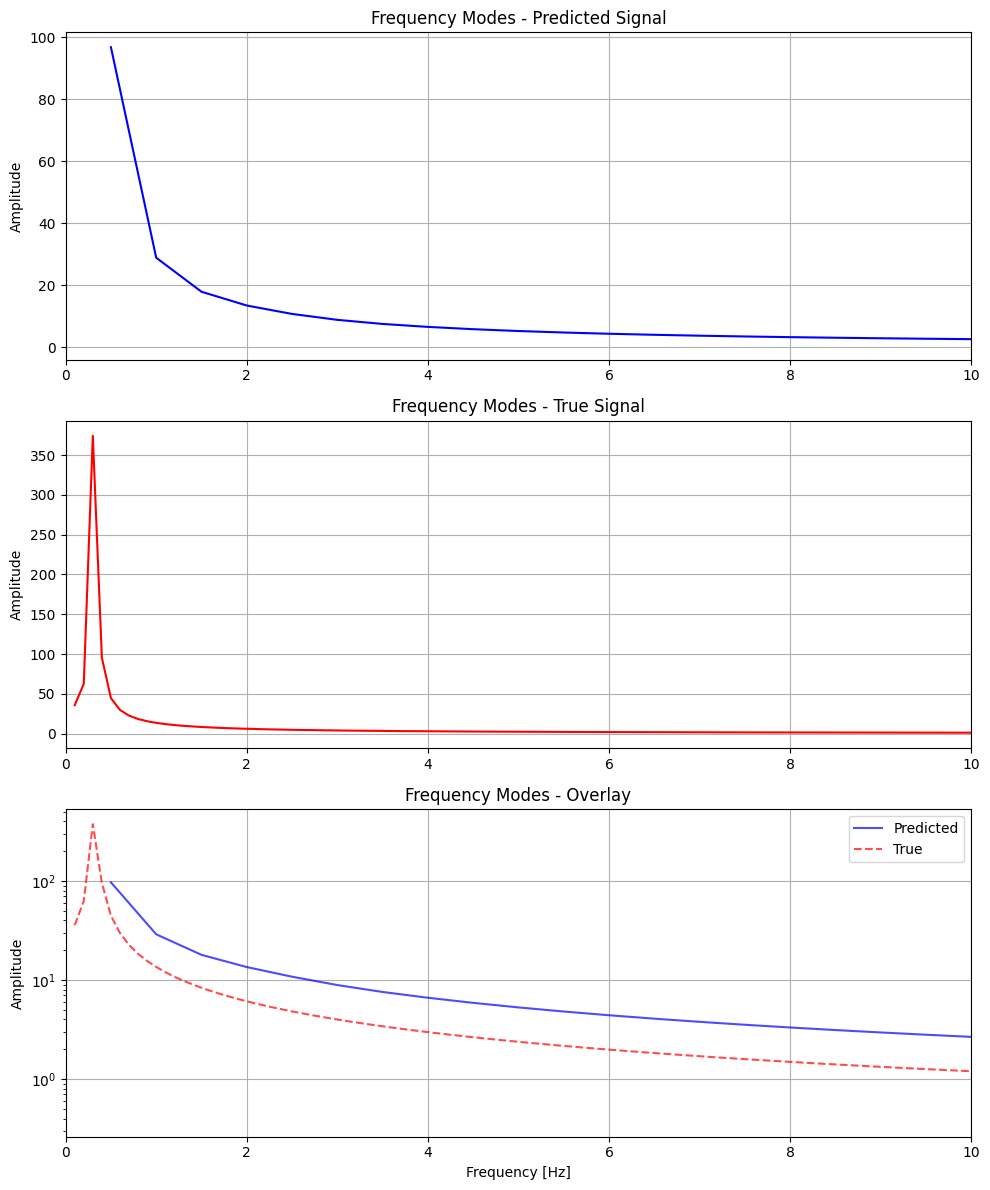

In [39]:
plot_spetrogram(pred_full, solution)


## Change Activation to Snake


In [42]:
class SnakeActivation(nn.Module):
    def __init__(self, a=1.0, requires_grad=True):
        super(SnakeActivation, self).__init__()
        # Initialize parameter 'a' as a learnable parameter
        self.a = nn.Parameter(torch.tensor(float(a)), requires_grad=requires_grad)
    
    def forward(self, x):
        return x + torch.sin(self.a * x)**2 / self.a
    
    def extra_repr(self) -> str:
        # This provides a nice string representation when printing the layer
        return f'a={self.a.item():.3f}'


In [21]:
# Define the Neural ODE model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.snake_activation = snake_activation
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            self.snake_activation,
            nn.Linear(32, 32),
            self.snake_activation,
            nn.Linear(32, 2)
        )
    
    def forward(self, t, y):
        return self.net(y)